In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Thu Jan 11 22:06:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    13W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-16/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


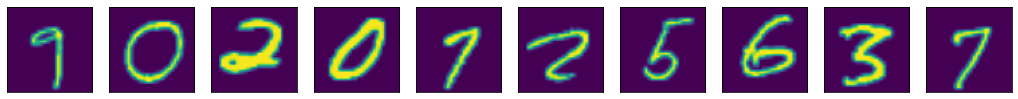

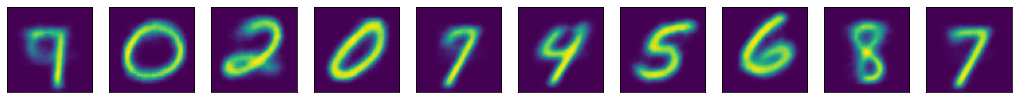

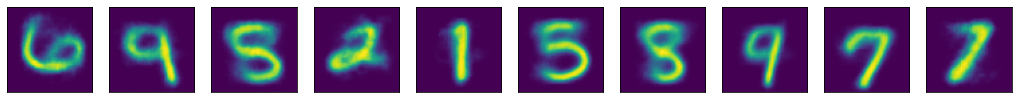

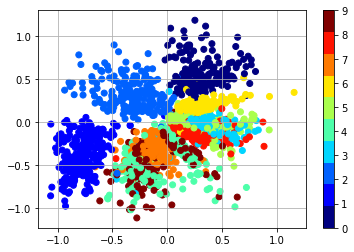

11001
lse_loss 0.00012190639972686768
recon_loss 0.1028950959444046
11002
lse_loss 0.00014807924162596464
recon_loss 0.10270929336547852
11003
lse_loss 0.00017391097208019346
recon_loss 0.10352855175733566
11004
lse_loss 0.00011855589400511235
recon_loss 0.10417771339416504
11005
lse_loss 0.00014781957725062966
recon_loss 0.10407723486423492
11006
lse_loss 0.00014754320727661252
recon_loss 0.10109653323888779
11007
lse_loss 0.0001230041089002043
recon_loss 0.10049881786108017
11008
lse_loss 0.0004956386983394623
recon_loss 0.11196073144674301
11009
lse_loss 0.00016211408365052193
recon_loss 0.10279805958271027
11010
lse_loss 0.00015571783296763897
recon_loss 0.1061752587556839
11011
lse_loss 0.0001449508999940008
recon_loss 0.10865117609500885
11012
lse_loss 0.00024342667893506587
recon_loss 0.10963727533817291
11013
lse_loss 0.00012391335621941835
recon_loss 0.10054980218410492
11014
lse_loss 0.00012955957208760083
recon_loss 0.10645502805709839
11015
lse_loss 0.00016028195386752486
r

11121
lse_loss 0.00013211628538556397
recon_loss 0.10335131734609604
11122
lse_loss 0.00017188562196679413
recon_loss 0.10330860316753387
11123
lse_loss 0.00013998230861034244
recon_loss 0.10903948545455933
11124
lse_loss 0.00013144040713086724
recon_loss 0.10986506938934326
11125
lse_loss 0.00012776360381394625
recon_loss 0.09597761929035187
11126
lse_loss 0.00015084160258993506
recon_loss 0.10208539664745331
11127
lse_loss 0.00013237789971753955
recon_loss 0.10112132132053375
11128
lse_loss 0.00014811905566602945
recon_loss 0.1049535721540451
11129
lse_loss 0.00013587417197413743
recon_loss 0.10500611364841461
11130
lse_loss 0.00011666577483993024
recon_loss 0.1049148440361023
11131
lse_loss 0.00012345734285190701
recon_loss 0.1005471870303154
11132
lse_loss 0.0001594570348970592
recon_loss 0.10050138831138611
11133
lse_loss 0.00015009492926765233
recon_loss 0.10566511005163193
11134
lse_loss 0.00013560999650508165
recon_loss 0.09872287511825562
11135
lse_loss 0.00017536482482682914


11241
lse_loss 0.0003128540702164173
recon_loss 0.10018619894981384
11242
lse_loss 0.00013143342221155763
recon_loss 0.10604891180992126
11243
lse_loss 0.0001244538143509999
recon_loss 0.10560600459575653
11244
lse_loss 0.00015187296958174556
recon_loss 0.09850674867630005
11245
lse_loss 0.00018595144501887262
recon_loss 0.10242941230535507
11246
lse_loss 0.00012455100659281015
recon_loss 0.10112850368022919
11247
lse_loss 0.0002328131376998499
recon_loss 0.10257752984762192
11248
lse_loss 0.0003475723206065595
recon_loss 0.10404954850673676
11249
lse_loss 0.00021641240164171904
recon_loss 0.10037368535995483
11250
lse_loss 0.0001352053805021569
recon_loss 0.09868311882019043
11251
lse_loss 0.0001529246219433844
recon_loss 0.1049967035651207
11252
lse_loss 0.00013136724010109901
recon_loss 0.1029646098613739
11253
lse_loss 0.00011975214147241786
recon_loss 0.10340162366628647
11254
lse_loss 0.00013141240924596786
recon_loss 0.1065891832113266
11255
lse_loss 0.0001405529328621924
recon_

11361
lse_loss 0.00016794857219792902
recon_loss 0.10571110248565674
11362
lse_loss 0.00016227219020947814
recon_loss 0.1080673560500145
11363
lse_loss 0.00017884702538140118
recon_loss 0.10938598960638046
11364
lse_loss 0.00012734130723401904
recon_loss 0.10796766728162766
11365
lse_loss 0.00017070828471332788
recon_loss 0.0987381860613823
11366
lse_loss 0.00018590540275909007
recon_loss 0.1089290976524353
11367
lse_loss 0.00017713337729219347
recon_loss 0.10200728476047516
11368
lse_loss 0.00017670681700110435
recon_loss 0.10835304856300354
11369
lse_loss 0.0001352639519609511
recon_loss 0.10655798763036728
11370
lse_loss 0.00014800853386987
recon_loss 0.11005805432796478
11371
lse_loss 0.00020362477516755462
recon_loss 0.10132195800542831
11372
lse_loss 0.00021343259140849113
recon_loss 0.10508197546005249
11373
lse_loss 0.00015439778508152813
recon_loss 0.10140947997570038
11374
lse_loss 0.00014134630328044295
recon_loss 0.09990546107292175
11375
lse_loss 0.0001640324480831623
reco

11481
lse_loss 0.00014877747162245214
recon_loss 0.10663501918315887
11482
lse_loss 0.00017874260083772242
recon_loss 0.09513092041015625
11483
lse_loss 0.00040608985000289977
recon_loss 0.1045522540807724
11484
lse_loss 0.00016579385555814952
recon_loss 0.10361190885305405
11485
lse_loss 0.0001421797787770629
recon_loss 0.10727262496948242
11486
lse_loss 0.0001214664735016413
recon_loss 0.10547288507223129
11487
lse_loss 0.00015560624888166785
recon_loss 0.10040586441755295
11488
lse_loss 0.00013419528841041028
recon_loss 0.10228313505649567
11489
lse_loss 0.00016124232206493616
recon_loss 0.10915292799472809
11490
lse_loss 0.0001785285712685436
recon_loss 0.10306792706251144
11491
lse_loss 0.00019252501078881323
recon_loss 0.1036253571510315
11492
lse_loss 0.00012798771786037832
recon_loss 0.10153673589229584
11493
lse_loss 0.0001844902872107923
recon_loss 0.10411705821752548
11494
lse_loss 0.00012852108920924366
recon_loss 0.09686373919248581
11495
lse_loss 0.0001464608940295875
rec

11602
lse_loss 0.00016226107254624367
recon_loss 0.10306733101606369
11603
lse_loss 0.0001606399309821427
recon_loss 0.1056489497423172
11604
lse_loss 0.00011846704001072794
recon_loss 0.10172905027866364
11605
lse_loss 0.0002423647092655301
recon_loss 0.09839636087417603
11606
lse_loss 0.00018148220260627568
recon_loss 0.10409891605377197
11607
lse_loss 0.0001559140218887478
recon_loss 0.10114608705043793
11608
lse_loss 0.00014081821427680552
recon_loss 0.10675405710935593
11609
lse_loss 0.00013356517592910677
recon_loss 0.10091039538383484
11610
lse_loss 0.00011795981117757037
recon_loss 0.10563604533672333
11611
lse_loss 0.00012096630234736949
recon_loss 0.09995292872190475
11612
lse_loss 0.00012044643517583609
recon_loss 0.10254785418510437
11613
lse_loss 0.00016815937124192715
recon_loss 0.103703074157238
11614
lse_loss 0.00016121569206006825
recon_loss 0.10265719890594482
11615
lse_loss 0.0001972497848328203
recon_loss 0.10640569031238556
11616
lse_loss 0.00016700895503163338
rec

11722
lse_loss 0.0001671703503234312
recon_loss 0.1090790256857872
11723
lse_loss 0.0001897392503451556
recon_loss 0.10278439521789551
11724
lse_loss 0.0001865649246610701
recon_loss 0.10284446179866791
11725
lse_loss 0.000133487832499668
recon_loss 0.09570159018039703
11726
lse_loss 0.00016678990505170077
recon_loss 0.10371813178062439
11727
lse_loss 0.000134473797515966
recon_loss 0.10237618535757065
11728
lse_loss 0.00015180133050307631
recon_loss 0.10437609255313873
11729
lse_loss 0.00022832569084130228
recon_loss 0.11073716729879379
11730
lse_loss 0.00013074878370389342
recon_loss 0.10245593637228012
11731
lse_loss 0.00017177137488033623
recon_loss 0.1008017510175705
11732
lse_loss 0.00016954209422692657
recon_loss 0.10960815846920013
11733
lse_loss 0.00017341409693472087
recon_loss 0.10700484365224838
11734
lse_loss 0.00013402571494225413
recon_loss 0.1040254458785057
11735
lse_loss 0.00018239850760437548
recon_loss 0.10466655343770981
11736
lse_loss 0.00014742600615136325
recon_

11842
lse_loss 0.00011960254050791264
recon_loss 0.09939353168010712
11843
lse_loss 0.00013148589641787112
recon_loss 0.10915639996528625
11844
lse_loss 0.000161415635375306
recon_loss 0.1071668490767479
11845
lse_loss 0.0001877539325505495
recon_loss 0.09971390664577484
11846
lse_loss 0.0004926960682496428
recon_loss 0.10888358950614929
11847
lse_loss 0.0003681229136418551
recon_loss 0.10791134834289551
11848
lse_loss 0.000171721912920475
recon_loss 0.09865297377109528
11849
lse_loss 0.00021997137810103595
recon_loss 0.10560391843318939
11850
lse_loss 0.00013043636863585562
recon_loss 0.10252108424901962
11851
lse_loss 0.00012608675751835108
recon_loss 0.09879948943853378
11852
lse_loss 0.0001329739752691239
recon_loss 0.10310547053813934
11853
lse_loss 0.0001288463536184281
recon_loss 0.10092105716466904
11854
lse_loss 0.00021395488874986768
recon_loss 0.09896165132522583
11855
lse_loss 0.00015313568292185664
recon_loss 0.10166728496551514
11856
lse_loss 0.00015505556075368077
recon_

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        